# 1. Install/import thư viện

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import re
import csv
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import datetime
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from pandas import DataFrame

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox
from itertools import product
from tqdm.notebook import tqdm
from datetime import date, timedelta

# 2. Import data

In [10]:
msft_df = pd.read_csv('../data/FPT.csv')

In [11]:
msft_df['Date'] = pd.to_datetime(msft_df['Ngày'], dayfirst=True)
msft_df.set_index('Date', inplace=True)

msft_df = msft_df.rename(columns={
    'Lần cuối': 'Close',
    'Mở': 'Open',
    'Cao': 'High',
    'Thấp': 'Low',
    'KL': 'Volume',
    '% Thay đổi': 'Change'
})

def parse_volume(val):
    if isinstance(val, str):
        val = val.replace(',', '')
        if val.endswith('K'):
            return float(val[:-1]) * 1_000
        elif val.endswith('M'):
            return float(val[:-1]) * 1_000_000
        elif val.endswith('B'):
            return float(val[:-1]) * 1_000_000_000
    try:
        return float(val)
    except:
        return None

msft_df['Volume'] = msft_df['Volume'].apply(parse_volume)

cols_to_clean = ['Close', 'Open', 'High', 'Low']
for col in cols_to_clean:
    msft_df[col] = msft_df[col].astype(str).str.replace(',', '', regex=False)
    msft_df[col] = pd.to_numeric(msft_df[col], errors='coerce')
    
msft_df = msft_df.drop(columns=['Ngày', 'Change'])

msft_df

,Close,Open,High,Low,Volume
Date,,,,,
2020-01-02,34887.5,34708.9,35125.6,34530.3,1420000.0
2020-01-03,34292.1,35066.1,35185.1,34173.1,3250000.0
2020-01-06,33934.9,33994.4,34292.1,33815.8,1730000.0
2020-01-07,34589.8,34113.5,34589.8,33934.9,1330000.0
2020-01-08,33815.8,34232.6,34351.7,33815.8,2880000.0
...,...,...,...,...,...
2025-04-03,113500.0,114700.0,117600.0,113500.0,11480000.0
2025-04-04,113000.0,105600.0,113900.0,105600.0,21570000.0
2025-04-08,105100.0,106000.0,108000.0,105100.0,16280000.0


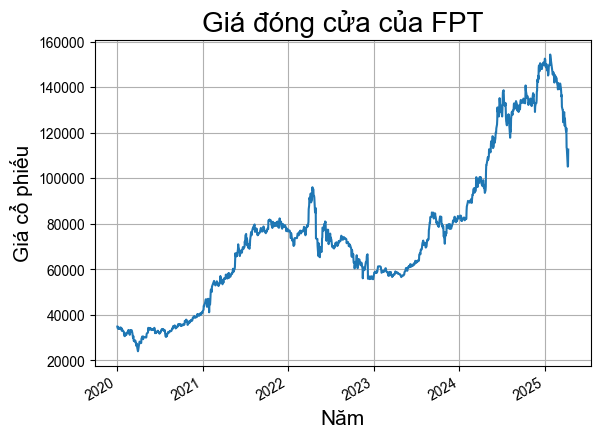

In [12]:
msft_df['Close'].plot(grid = True)
sns.set(rc={'figure.figsize':(15, 9)})
plt.title('Giá đóng cửa của FPT', color = 'black', fontsize = 20)
plt.xlabel('Năm', color = 'black', fontsize = 15)
plt.ylabel('Giá cổ phiếu', color = 'black', fontsize = 15);

# 3. Moving Average

In [13]:
msft_adj = msft_df[['Close']]
msft_adj 

,Close
Date,
2020-01-02,34887.5
2020-01-03,34292.1
2020-01-06,33934.9
2020-01-07,34589.8
2020-01-08,33815.8
...,...
2025-04-03,113500.0
2025-04-04,113000.0
2025-04-08,105100.0


In [14]:
split = int(0.8*len(msft_adj))

In [15]:
train, test = msft_adj[:split], msft_adj[split:]

In [16]:
msft_adj.shape, train.shape, test.shape

((1315, 1), (1052, 1), (263, 1))

In [17]:
train.index.min(), train.index.max(), test.index.min(), test.index.max()

(Timestamp('2020-01-02 00:00:00'),
 Timestamp('2024-03-20 00:00:00'),
 Timestamp('2024-03-21 00:00:00'),
 Timestamp('2025-04-10 00:00:00'))

### Tạo dự đoán cho test set

In [18]:
preds = []
for i in range(0,263):
    a = train[len(train)-263+i:].sum() + sum(preds)
    b = a/263
    preds.append(b)

In [19]:
mse = mean_squared_error(test, preds)
mae = mean_absolute_error(test, preds)
r2 = r2_score(test, preds)
rmse = np.sqrt(mse)

print(f"MSE  = {mse:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"MAE  = {mae:.4f}")
print(f"R²   = {r2:.4f}")

MSE  = 2716318475.0374
RMSE = 52118.3123
MAE  = 50529.7038
R²   = -11.8100


### Trực quan hóa các dữ liệu dự đoán và thực tế

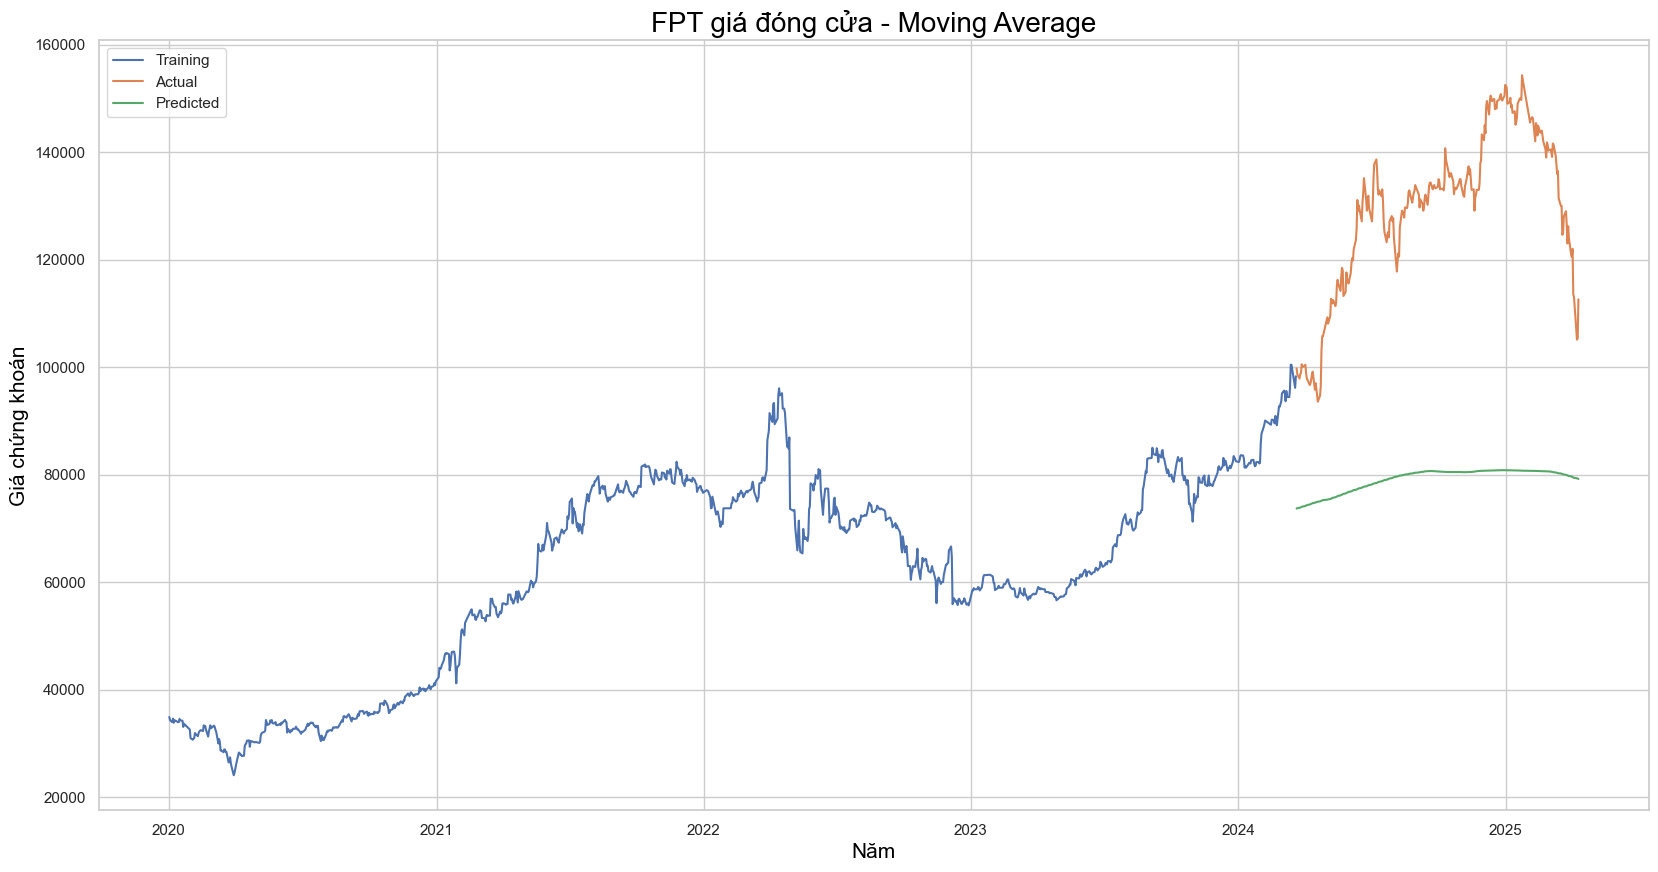

In [20]:
plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
test['Predictions'] = 0
test['Predictions'] = preds
plt.plot(train, label='Training')
plt.plot(test['Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("FPT giá đóng cửa - Moving Average", color = 'black', fontsize = 20)
plt.xlabel('Năm', color = 'black', fontsize = 15)
plt.ylabel('Giá chứng khoán', color = 'black', fontsize = 15)
plt.legend();

# 4. Linear Regression

In [21]:
msft_adj['Date'] = pd.to_datetime(msft_adj.index, format='%Y-%m-%d')
msft_adj.index = msft_adj['Date']

In [22]:
msft_adj = pd.DataFrame(index=range(0,len(msft_df)),columns=['Date', 'Close'])

for i in range(0,len(msft_df)):
     msft_adj['Date'][i] = msft_df.index[i]
     msft_adj['Close'][i] = msft_df['Close'][i]

## Feature engineering

In [23]:
def add_datepart(df, fldname, drop=True, time=False):
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [24]:
add_datepart(msft_adj, 'Date')
msft_adj.drop('Elapsed', axis=1, inplace=True) 

In [25]:
msft_adj.columns

Index(['Close', 'Year', 'Month', 'Day', 'Dayofweek', 'Dayofyear',
       'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
       'Is_year_end', 'Is_year_start'],
      dtype='object')

In [26]:
msft_adj['mon_fri'] = 0
for i in range(0,len(msft_adj)):
    if (msft_adj['Dayofweek'][i] == 0 or msft_adj['Dayofweek'][i] == 4):
        msft_adj['mon_fri'][i] = 1
    else:
        msft_adj['mon_fri'][i] = 0

### Split data thành train và test set 

In [27]:
split = int(0.8*len(msft_adj))

In [28]:
train, test = msft_adj[:split], msft_adj[split:]

In [29]:
msft_adj.shape, train.shape, test.shape

((1315, 13), (1052, 13), (263, 13))

In [30]:
X_train = train.drop('Close', axis=1)
y_train = train['Close']
X_test = test.drop('Close', axis=1)
y_test = test['Close']

In [31]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1052, 12), (1052,), (263, 12), (263,))

### Tạo và train mô hình Hồi quy tuyến tính


In [32]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

### Test model

In [33]:
preds = model.predict(X_test)

In [34]:
mse = mean_squared_error(y_test, preds)
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)
rmse = np.sqrt(mse)

print(f"MSE  = {mse:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"MAE  = {mae:.4f}")
print(f"R²   = {r2:.4f}")

MSE  = 1907912997.7766
RMSE = 43679.6634
MAE  = 41451.7821
R²   = -7.9976


### Trực quan hóa các dữ liệu dự đoán và thực tế

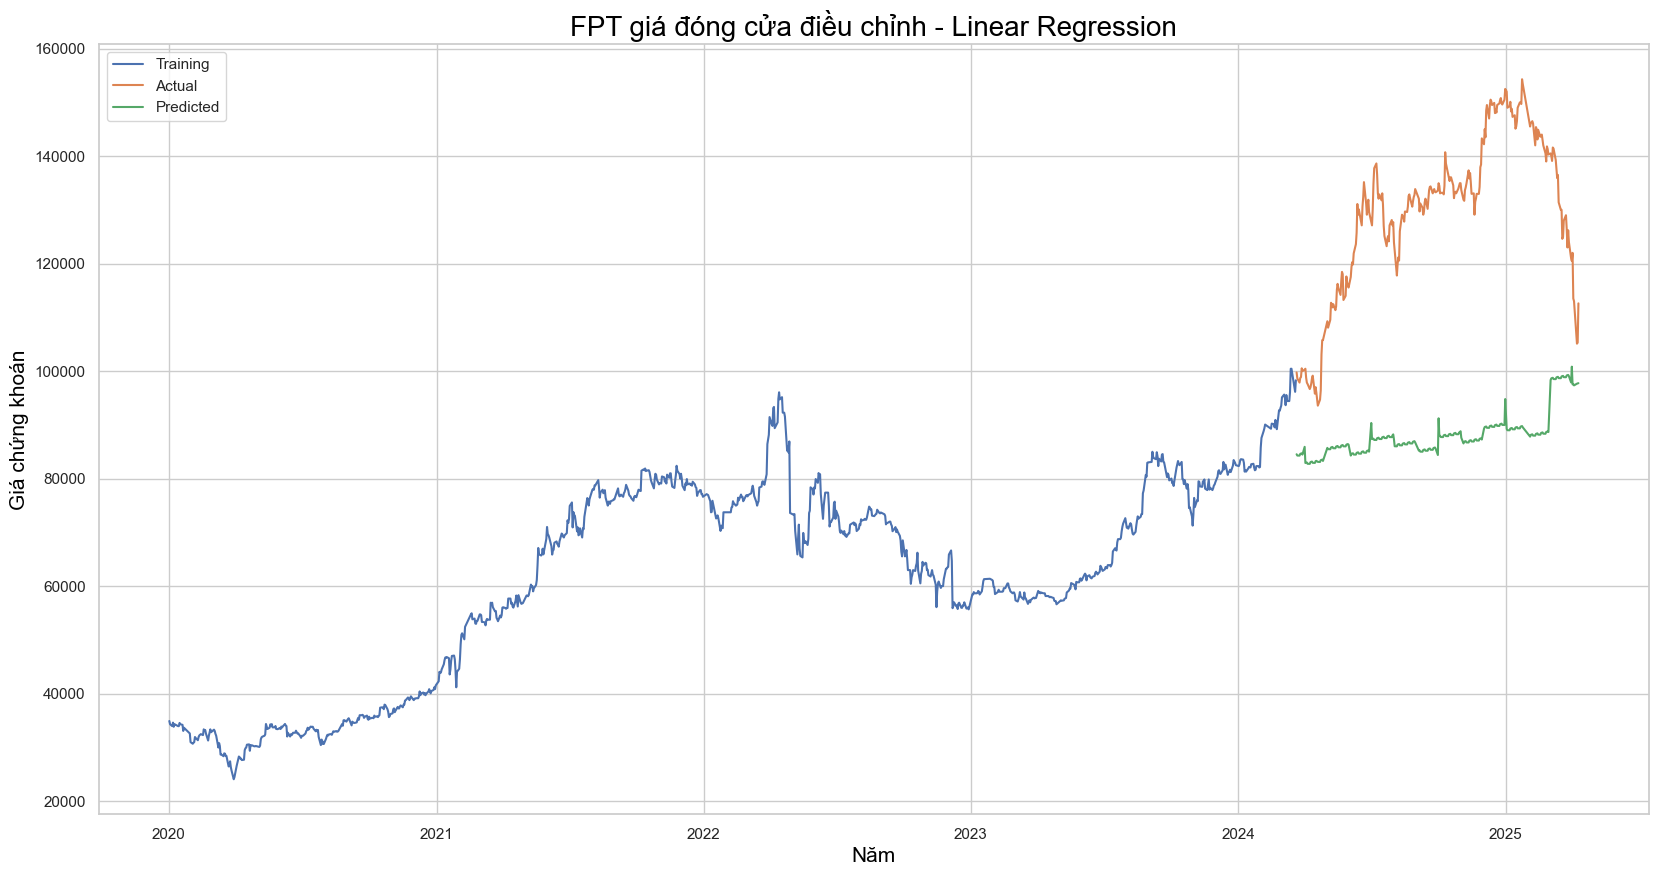

In [35]:
# Plot thông số dự đoán và thực tế
plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
test['Predictions'] = 0
test['Predictions'] = preds

test.index = msft_df[split:].index
train.index = msft_df[:split].index

plt.plot(train['Close'], label='Training')
plt.plot(test['Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("FPT giá đóng cửa điều chỉnh - Linear Regression", color = 'black', fontsize = 20)
plt.xlabel('Năm', color = 'black', fontsize = 15)
plt.ylabel('Giá chứng khoán', color = 'black', fontsize = 15)
plt.legend();

# 5. k-Nearest Neighbours

## Feature scaling

In [36]:
scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled)
X_test_scaled = scaler.transform(X_test) 
X_test = pd.DataFrame(X_test_scaled)

### GridSearch tìm tham số tối ưu

In [37]:
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

### Train và test model

In [38]:
model.fit(X_train,y_train)
preds = model.predict(X_test)

In [39]:
mse = mean_squared_error(y_test, preds)
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)
rmse = np.sqrt(mse)

print(f"MSE  = {mse:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"MAE  = {mae:.4f}")
print(f"R²   = {r2:.4f}")

MSE  = 2789217252.1056
RMSE = 52813.0405
MAE  = 49985.2485
R²   = -12.1538


### Trực quan hóa các dữ liệu dự đoán và thực tế

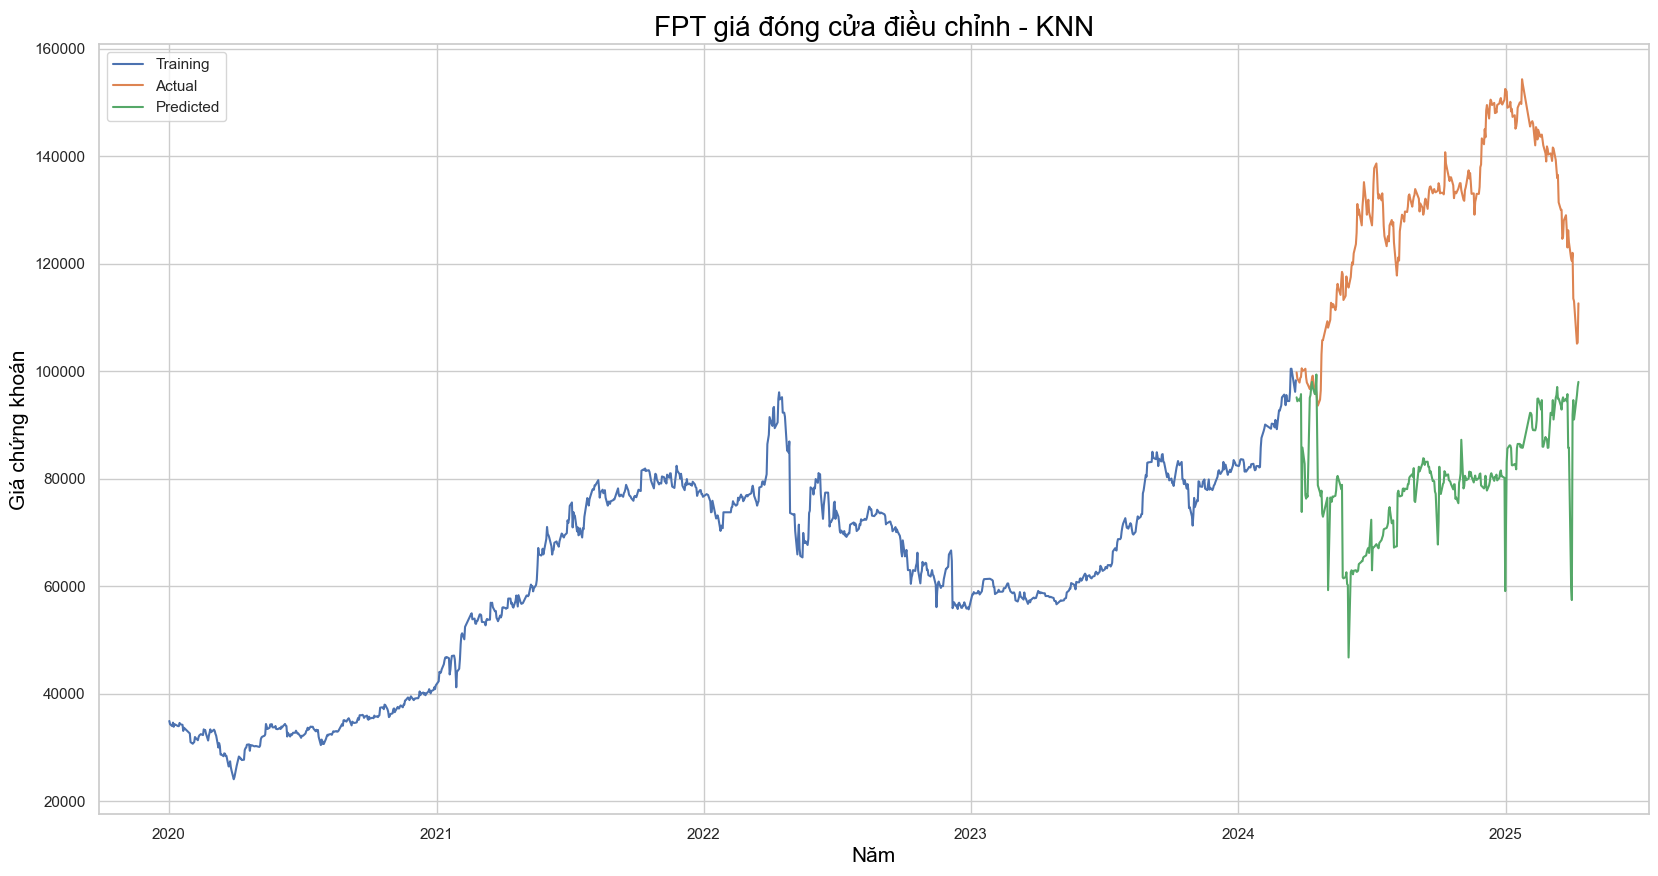

In [40]:
# Plot thông số dự đoán và thực tế
plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
test['Predictions'] = 0
test['Predictions'] = preds

plt.plot(train['Close'], label='Training')
plt.plot(test['Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("FPT giá đóng cửa điều chỉnh - KNN", color = 'black', fontsize = 20)
plt.xlabel('Năm', color = 'black', fontsize = 15)
plt.ylabel('Giá chứng khoán', color = 'black', fontsize = 15)
plt.legend();

# 6. Prophet

In [41]:
msft_adj = pd.DataFrame(index=range(0,len(msft_df)),columns=['Date', 'Close'])

for i in range(0,len(msft_df)):
     msft_adj['Date'][i] = msft_df.index[i]
     msft_adj['Close'][i] = msft_df['Close'][i]

In [42]:
msft_adj['Date'] = pd.to_datetime(msft_adj.Date,format='%Y-%m-%d')
msft_adj.index = msft_adj['Date']

In [43]:
msft_adj.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

### Split data thành train và test sets

In [44]:
split = int(0.8*len(msft_adj))

In [45]:
train, test = msft_adj[:split], msft_adj[split:]

In [46]:
msft_adj.shape, train.shape, test.shape

((1315, 2), (1052, 2), (263, 2))

### Tạo và train model

In [47]:
model = Prophet()
model.fit(train)

23:57:11 - cmdstanpy - INFO - Chain [1] start processing
23:57:12 - cmdstanpy - INFO - Chain [1] done processing


### Test model

Sau đó, dự đoán được thực hiện trên DataFrame với cột **ds** chứa ngày dự đoán sẽ được thực hiện. 

In [48]:
close_prices = model.make_future_dataframe(periods=len(test))
forecast = model.predict(close_prices)

### Tính chỉ số RMSE

In [49]:
forecast_test = forecast['yhat'][split:]

mse = mean_squared_error(test['y'], forecast_test)
mae = mean_absolute_error(test['y'], forecast_test)
r2 = r2_score(test['y'], forecast_test)
rmse = np.sqrt(mse)

print(f"MSE  = {mse:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"MAE  = {mae:.4f}")
print(f"R²   = {r2:.4f}")

MSE  = 422973045.6969
RMSE = 20566.3085
MAE  = 18787.0367
R²   = -0.9947


### Trực quan hóa các dữ liệu dự đoán và thực tế

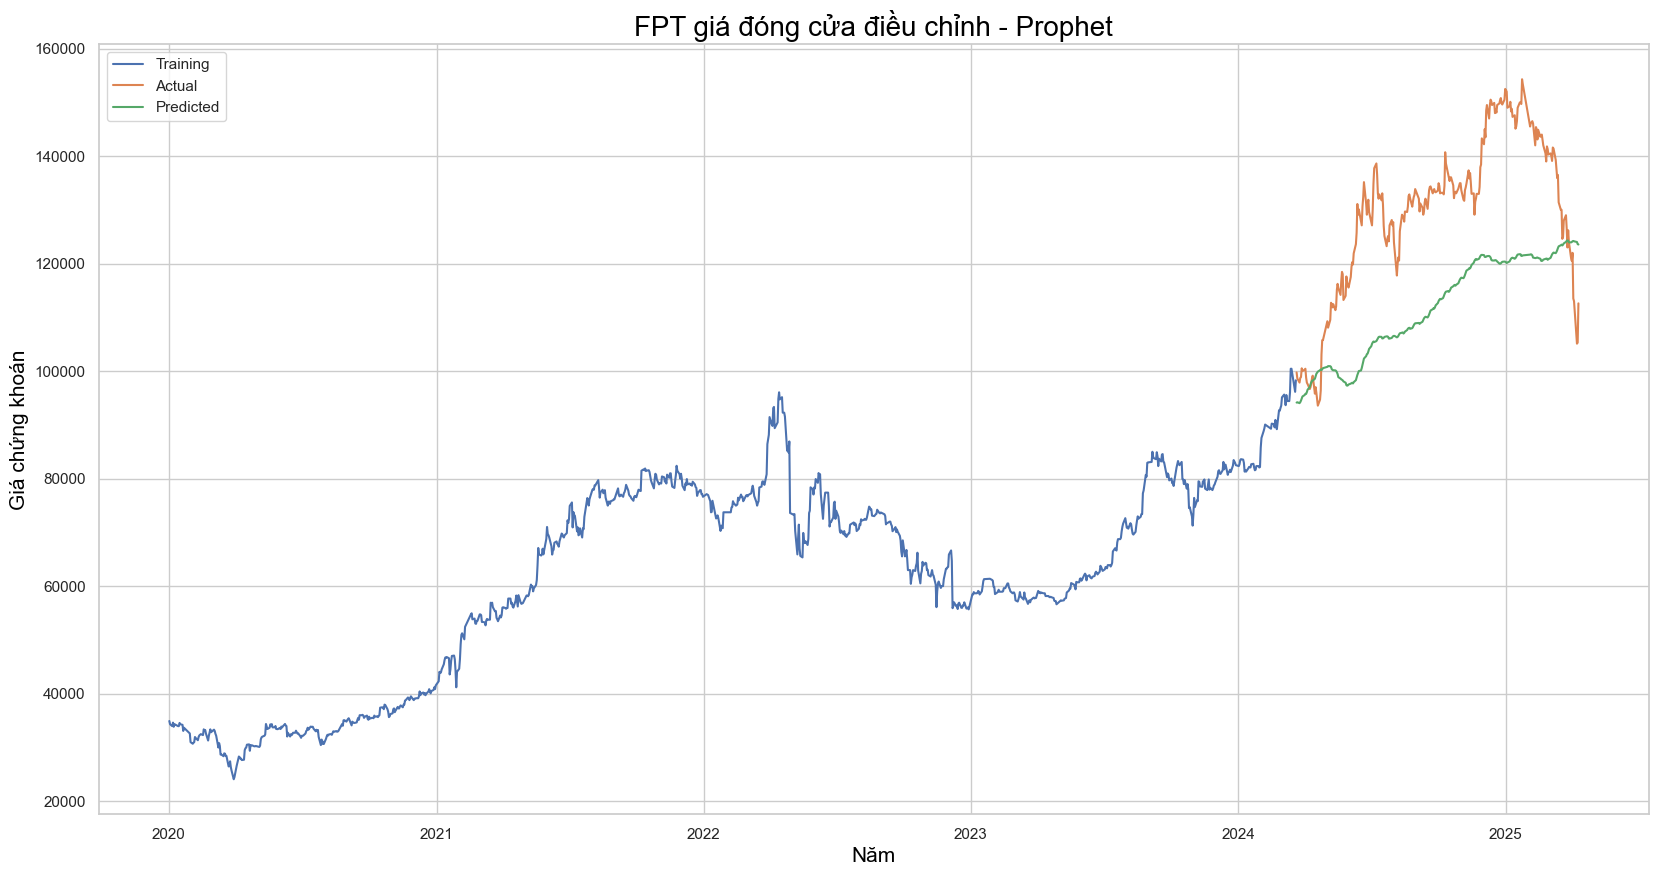

In [50]:
# Plot thông số dự đoán và thực tế
test['Predictions'] = 0
test['Predictions'] = forecast_test.values

plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
plt.plot(train['y'], label='Training')
plt.plot(test['y'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("FPT giá đóng cửa điều chỉnh - Prophet", color = 'black', fontsize = 20)
plt.xlabel('Năm', color = 'black', fontsize = 15)
plt.ylabel('Giá chứng khoán', color = 'black', fontsize = 15)
plt.legend();

# 7. Long Short Term Memory (LSTM)

In [51]:
msft_adj = msft_df[['Close']]
msft_adj 

,Close
Date,
2020-01-02,34887.5
2020-01-03,34292.1
2020-01-06,33934.9
2020-01-07,34589.8
2020-01-08,33815.8
...,...
2025-04-03,113500.0
2025-04-04,113000.0
2025-04-08,105100.0


In [52]:
msft_adj_arr = msft_adj.values

### Split data thành train và test set

In [53]:
split = int(0.8*len(msft_adj_arr))

In [54]:
train, test = msft_adj_arr[:split], msft_adj_arr[split:]

In [55]:
train.shape, test.shape

((1052, 1), (263, 1))

## Feature scaling

In [56]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(msft_adj_arr)

## Tạo dữ liệu training

In [57]:
X_train, y_train = [], []
for i in range(60,len(train)):
    X_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])

In [58]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [59]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(992, 60, 1)

### Tạo và train model

Chúng ta sẽ triển khai một mô hình đơn giản bao gồm một lớp ẩn với 50 nơ-ron, hình dạng dữ liệu đầu vào với số bước thời gian (number of time steps) là (60) và số chiều (dimensionality) là (1) và một lớp đầu ra với bước thời gian là 1. Mô hình sẽ được biên dịch bằng Mean Squared Error (MSE) và trình tối ưu hóa ADAM (Adaptive Moment Estimation), sau đó sẽ được fit với training set với một epoch và batch size là một.

In [60]:
# Tạo và fit mạng LSTM 
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=2)

# Dự đoán 504 giá trị, sự dụng 60 từ tập data train 
inputs = msft_adj_arr [len(msft_adj_arr) - len(test) - 60:]
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

992/992 - 17s - 17ms/step - loss: 0.0013


### Tạo test set và test

In [61]:
# Tạo test data set
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])

# Chuyển data thành numpy array
X_test = np.array(X_test)

# Chuyển data thành 3-D
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
adj_closing_price = model.predict(X_test)
adj_closing_price = scaler.inverse_transform(adj_closing_price)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


In [62]:
print(X_test.shape)

(263, 60, 1)


### Tính chỉ số RMSE

In [63]:
mse = mean_squared_error(test, adj_closing_price)
mae = mean_absolute_error(test, adj_closing_price)
r2 = r2_score(test, adj_closing_price)
rmse = np.sqrt(mse)

print(f"MSE  = {mse:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"MAE  = {mae:.4f}")
print(f"R²   = {r2:.4f}")

MSE  = 19871057.5608
RMSE = 4457.6964
MAE  = 3578.4910
R²   = 0.9063


### Trực quan hóa các dữ liệu dự đoán và thực tế

In [64]:
last_60_days = scaled_data[-60:]

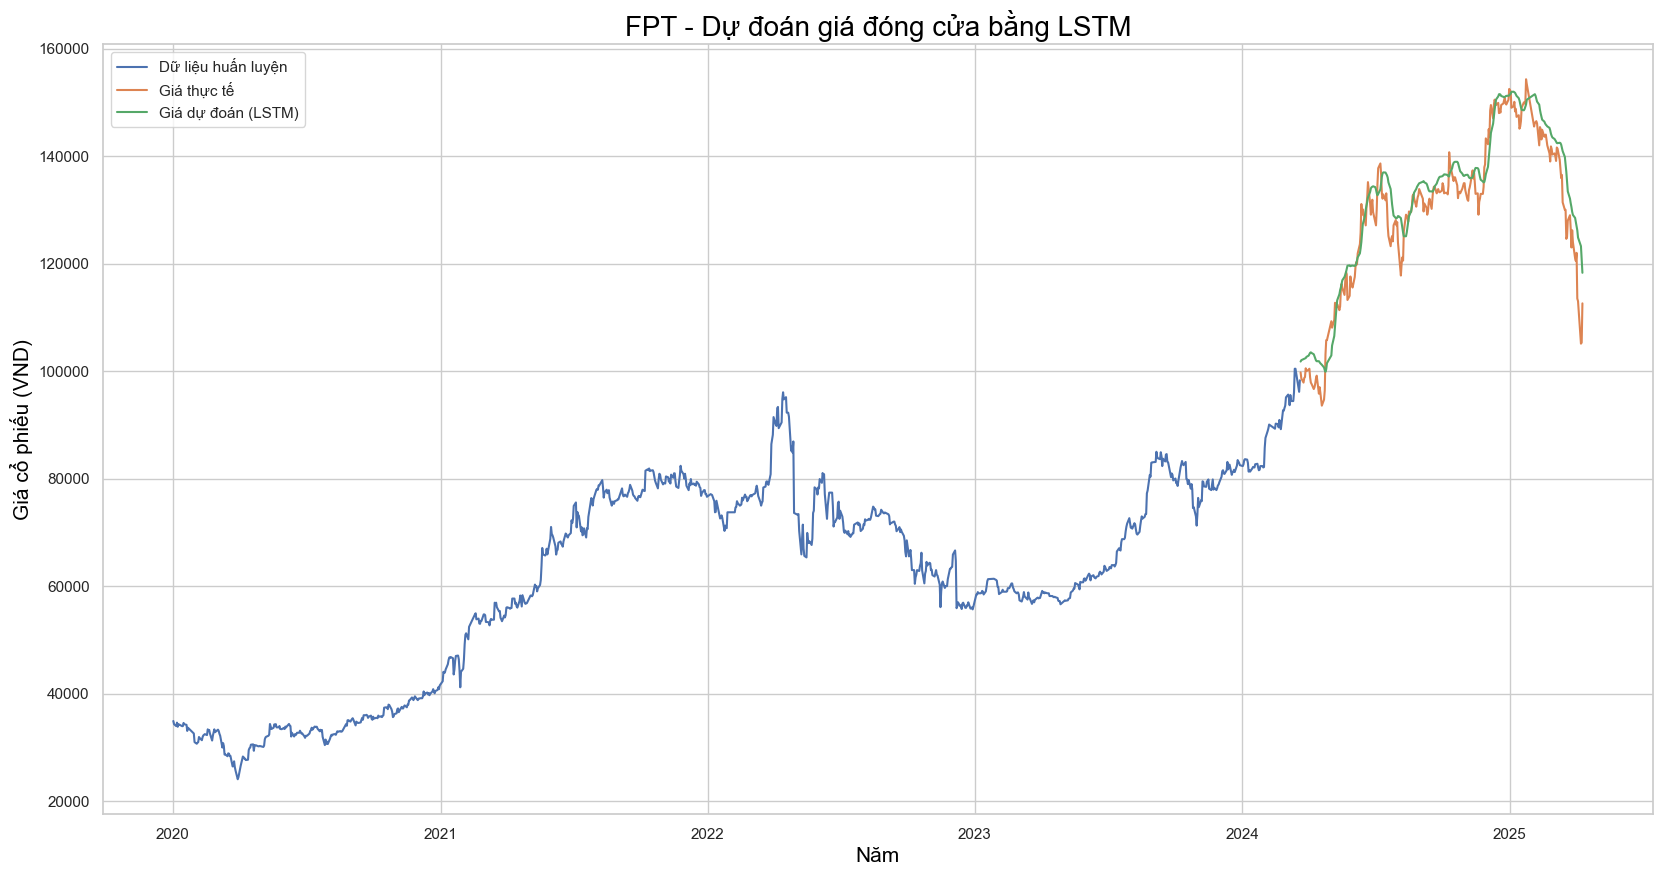

In [65]:
# Plot thông số dự đoán và thực tế
train = msft_adj[:split]
test = msft_adj[split:]
test['Predictions'] = adj_closing_price

plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
plt.plot(train['Close'], label='Dữ liệu huấn luyện')
plt.plot(test['Close'], label='Giá thực tế')
plt.plot(test['Predictions'], label='Giá dự đoán (LSTM)')
plt.title("FPT - Dự đoán giá đóng cửa bằng LSTM", color='black', fontsize=20)
plt.xlabel('Năm', color='black', fontsize=15)
plt.ylabel('Giá cổ phiếu (VND)', color='black', fontsize=15)
plt.legend()

# Lưu ảnh ra file
# plt.savefig('/kaggle/working/MBB.png')

Last available date in dataset: 2025-04-10 00:00:00
Epoch 1/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0567
Epoch 2/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0028
Epoch 3/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0023
Epoch 4/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0020
Epoch 5/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0025
Epoch 6/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0021
Epoch 7/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - loss: 0.0026
Epoch 8/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.0017
Epoch 9/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0021
Epoch 10/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0018
Epoch 11/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0020
Epoch 12/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0018
Epoch 13/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0020
Epoch 14/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.0019
Epoch 15/25
40/40 

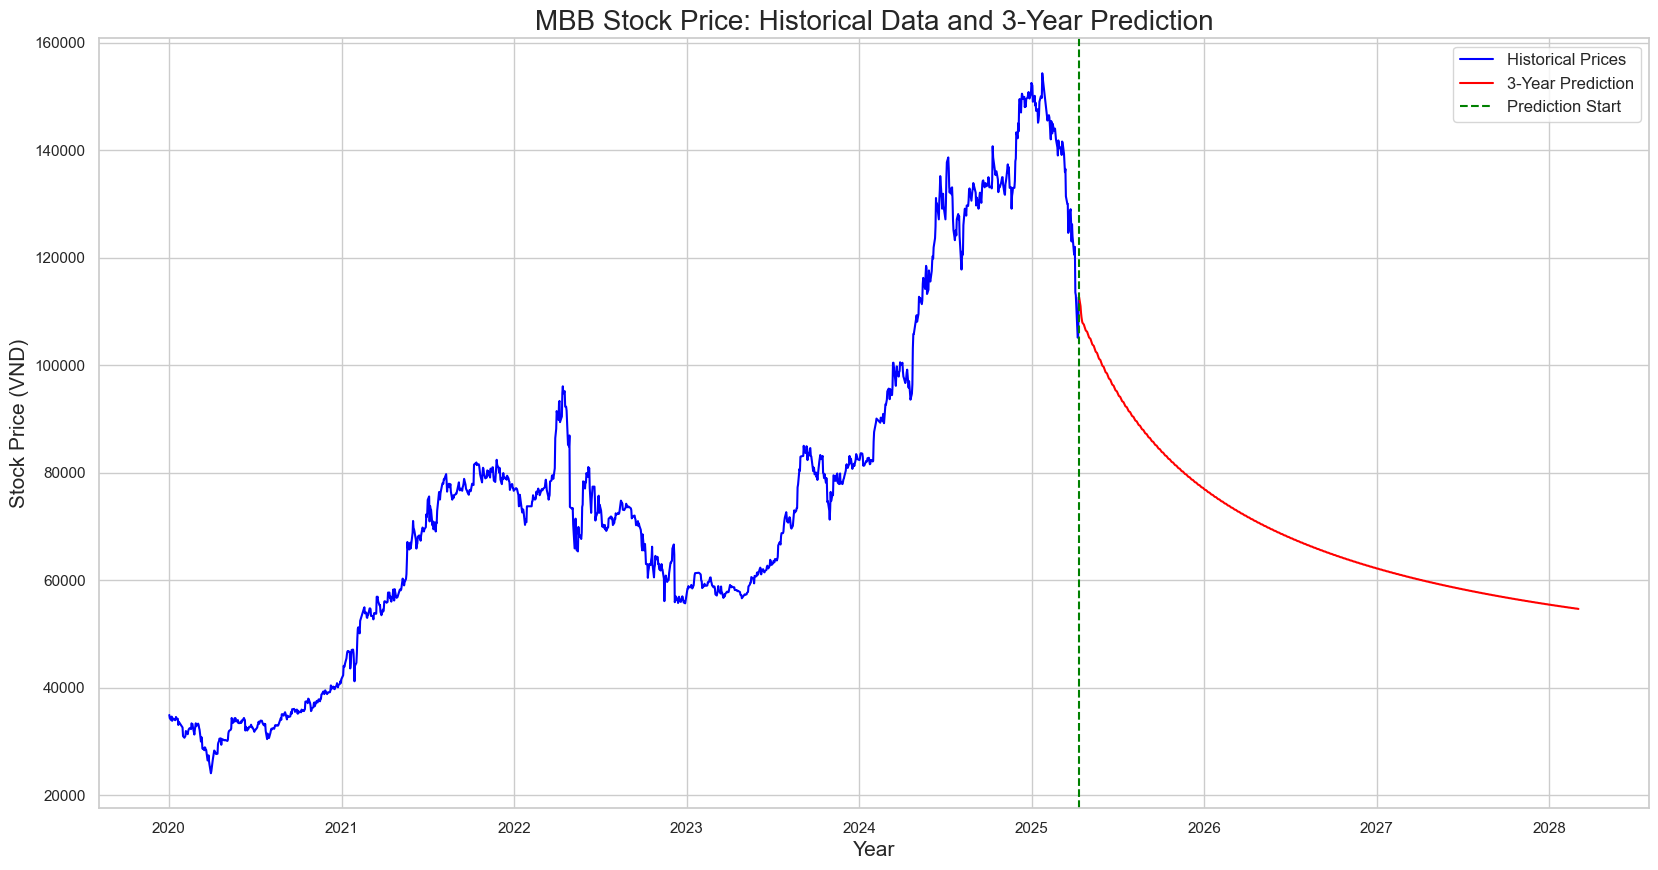


Prediction Summary Statistics:
Minimum Predicted Price: 54626.80 VND
Maximum Predicted Price: 112617.26 VND
Average Predicted Price: 69552.07 VND
Final Predicted Price: 54626.80 VND

Projected Year-by-Year Growth:
Year 1 (Until 2026-03-30): -36.08%
Year 2 (Until 2027-03-17): -16.07%
Year 3 (Until 2028-03-03): -9.57%
Total 3-Year Growth: -51.49%


In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set up visualization parameters
sns.set(rc={'figure.figsize':(20, 10)})
sns.set_style("whitegrid")

# Reload and prepare the data
msft_df = pd.DataFrame(msft_df)  # Assuming msft_df is already loaded from your code

# Make a copy to avoid modifying original data
df = msft_df.copy()


msft_adj = df[['Close']]

# Convert to numpy array
msft_adj_arr = msft_adj.values

# Feature scaling for all data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(msft_adj_arr)

# Get the last available date from the dataframe
last_date = df.index[-1]
print(f"Last available date in dataset: {last_date}")

# Use all available data for training the final model
X_all, y_all = [], []
window_size = 60  # Using 60 days of history to predict the next day

for i in range(window_size, len(scaled_data)):
    X_all.append(scaled_data[i-window_size:i, 0])
    y_all.append(scaled_data[i, 0])

X_all, y_all = np.array(X_all), np.array(y_all)
X_all = np.reshape(X_all, (X_all.shape[0], X_all.shape[1], 1))

# Create and train an enhanced LSTM model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_all.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_all, y_all, epochs=25, batch_size=32, verbose=1)

# Function to generate future predictions
def predict_future(model, last_sequence, num_days, scaler):
    future_predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(num_days):
        # Reshape for prediction
        current_sequence_reshaped = np.reshape(current_sequence, (1, window_size, 1))
        
        # Get prediction (scaled)
        next_pred_scaled = model.predict(current_sequence_reshaped)[0, 0]
        
        # Save the prediction
        future_predictions.append(next_pred_scaled)
        
        # Update sequence for next prediction (remove oldest, add newest)
        current_sequence = np.append(current_sequence[1:], next_pred_scaled)
    
    # Convert scaled predictions back to original scale
    future_pred_array = np.array(future_predictions).reshape(-1, 1)
    future_predictions_actual = scaler.inverse_transform(future_pred_array)
    
    return future_predictions_actual.flatten()

# Get the last sequence from our data
last_sequence = scaled_data[-window_size:, 0]

# Generate trading dates for the next 3 years (approximately 252 trading days per year)
trading_days_per_year = 252
prediction_days = trading_days_per_year * 3  # 3 years

# Generate future dates (considering only trading days, roughly)
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=prediction_days, freq='B')

# Predict the next 3 years
future_predictions = predict_future(model, last_sequence, prediction_days, scaler)

# Create a DataFrame with the predictions
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': future_predictions
})
future_df.set_index('Date', inplace=True)

# Create final plot
plt.figure(figsize=(20, 10))

# Plot historical data
plt.plot(df.index, df['Close'], label='Historical Prices', color='blue')

# Plot future predictions
plt.plot(future_df.index, future_df['Predicted_Close'], label='3-Year Prediction', color='red')

# Add a vertical line to mark the boundary between historical and predicted data
plt.axvline(x=last_date, color='green', linestyle='--', label='Prediction Start')

# Add labels and title
plt.title('MBB Stock Price: Historical Data and 3-Year Prediction', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Stock Price (VND)', fontsize=15)
plt.legend(fontsize=12)
plt.grid(True)

# Save the figure
plt.savefig('MBB_3year_prediction.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()

# Calculate summary statistics for predictions
print("\nPrediction Summary Statistics:")
print(f"Minimum Predicted Price: {future_df['Predicted_Close'].min():.2f} VND")
print(f"Maximum Predicted Price: {future_df['Predicted_Close'].max():.2f} VND")
print(f"Average Predicted Price: {future_df['Predicted_Close'].mean():.2f} VND")
print(f"Final Predicted Price: {future_df['Predicted_Close'].iloc[-1]:.2f} VND")

# Calculate year-by-year growth rates
year1_end = future_df.index[trading_days_per_year-1]
year2_end = future_df.index[trading_days_per_year*2-1]
year3_end = future_df.index[-1]

start_price = df['Close'].iloc[-1]
year1_price = future_df['Predicted_Close'].loc[year1_end]
year2_price = future_df['Predicted_Close'].loc[year2_end]
year3_price = future_df['Predicted_Close'].iloc[-1]

year1_growth = (year1_price / start_price - 1) * 100
year2_growth = (year2_price / year1_price - 1) * 100
year3_growth = (year3_price / year2_price - 1) * 100
total_growth = (year3_price / start_price - 1) * 100

print("\nProjected Year-by-Year Growth:")
print(f"Year 1 (Until {year1_end.strftime('%Y-%m-%d')}): {year1_growth:.2f}%")
print(f"Year 2 (Until {year2_end.strftime('%Y-%m-%d')}): {year2_growth:.2f}%")
print(f"Year 3 (Until {year3_end.strftime('%Y-%m-%d')}): {year3_growth:.2f}%")
print(f"Total 3-Year Growth: {total_growth:.2f}%")